# SSLTelecom

## Problema

Te escribimos de la peluquería SSL, esta pandemia – entre otras cosas –, ha afectado a nuestro negocio, que a veces parece que está a punto de cerrar, para nuestro disgusto. Como no queremos rendirnos tan fácilmente, hemos pensado en abrir un nuevo negocio de **venta de teléfonos móviles** para ver si sacamos suficientes beneficios para mantener la pelu a flote.

Supongo que a estas alturas, te estarás preguntando: ¿y yo qué pinto en el negocio? Pues la verdad, es que no sabemos muy bien qué precio ponerle a nuestros teléfonos móviles y no queremos quedar atrás de nuestros competidores. Es por eso que necesitamos la ayuda de un **orfebre Data Scientist** que nos ayude a estimar correctamente el rango de precio de un teléfono móvil (bajo/medio/alto) para nosotras podernos hacer una idea del precio final al que podemos venderlo y no perder dinero.

Hemos adjuntado el fichero con los datos que tenemos disponibles actualmente. Si necesitas un diccionario con información relativa a los datos, háznoslo saber.

## Datos

- **Battery power**: indica la batería del móvil expresada en mAh
- **Blue**: indica si el móvil tiene bluetooth (1) o no (0)
- **Clock speed**: indica la rapidez de procesamiento
- **Dual sim**: indica si el móvil soporta dos SIM (1) o no (0)
- **Fc**: megapíxeles de la cámara frontal
- **Four_g**: indica si el móvil tiene 4G (1) o no (0)
- **Int_memory**: memoria interna expresada en Gb
- **M_dep**: grosor del teléfono móvil
- **Mobile_wt**: peso del teléfono móvil
- **N_cores**: número de cores del procesador
- **Pc**: megapíxeles de la cámara principal
- **Px_height**: resolución de píxeles (altura)
- **Px_width**: resolución de píxeles (ancho)
- **Ram**: RAM del móvil expresada en MegaBytes
- **Sc_h**: altura de la pantalla del móvil expresada en cm
- **Sc_w**: ancho de la pantalla del móvil expresada en cm
- **Talk time**: duración de la batería durante una conversación
- **Three_g**: indica si el móvil tiene 3G (1) o no (0)
- **Touch_screen**: indica si la pantalla del móvil es táctil (1) o no (0)
- **WiFi**: indica si el móvil tiene WiFi (1) o no (0)
- **Price-range**: indica si el móvil es de costo bajo (0), medio (1), alto (2) o muy alto (3)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
import pandas as pd

DATA_FILEPATH = '../data/mobile_phone_info.csv'
df = pd.read_csv(DATA_FILEPATH)
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


## Modificando variables

Como vimos en el análisis exploratorio, las variables `px_height` y `sc_w` tienen valores que no son válidos. En ambos casos, estamos hablando de variables de tamaños. Vamos a calcular la ratio entre el ancho y el alto y vamos a aplicarla a la otra variable de tamaño para calcular el nuevo valor.

Calculamos la moda del ratio de la resolución de pantalla.

In [26]:
valid_px_height = df[df['px_height'] >= 500]
px_ration = valid_px_height['px_width'] / valid_px_height['px_height']
px_ration_mode = px_ration.mode()[0]
print(f"Moda de px_ration", px_ration_mode)

Moda de px_ration 1.1714285714285715


Calculamos la moda del ratio del tamaño de pantalla.

In [27]:
valid_sc_w = df[df['sc_w'] >= 3]
sc_ration = valid_sc_w['sc_w'] / valid_sc_w['sc_h']
sc_ration_mode = sc_ration.mode()[0]
print(f"Moda de sc_ration", sc_ration_mode)

Moda de sc_ration 0.5


### Creamos los Transformers

Lo primero es crear unos Transformers para eliminar los valores inválidos de la resolución y tamaño de pantalla. Para ello creamos el `ReplacePxRatio` y `ReplaceScRatio`.

In [28]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class ReplacePxRatio(BaseEstimator, TransformerMixin):
    def __init__(self, min_height_valid):
        self.min_height_valid = min_height_valid
    def fit(self, X, y=None):
        valid_px_height = X[X['px_height'] >= self.min_height_valid]
        px_ration = valid_px_height['px_width'] / valid_px_height['px_height']
        self.px_ration_mode = px_ration.mode()[0]
        return self
    def transform(self, X):
        new_df = X.copy()
        new_df['px_height'] = np.where(X['px_height'] >= self.min_height_valid, X['px_height'], X['px_width'] * self.px_ration_mode)
        return new_df
    
class ReplaceScRatio(BaseEstimator, TransformerMixin):
    def __init__(self, min_width_valid):
        self.min_width_valid = min_width_valid
    def fit(self, X, y=None):
        valid_sc_width = X[X['sc_w'] >= self.min_width_valid]
        sc_ration = valid_sc_width['sc_w'] / valid_sc_width['sc_h']
        self.sc_ration_mode = sc_ration.mode()[0]
        return self
    def transform(self, X):
        new_df = X.copy()
        new_df['sc_w'] = np.where(X['sc_w'] >= self.min_width_valid, X['sc_w'], X['sc_h'] * self.sc_ration_mode)
        return new_df

In [29]:
class DummyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X

## Pipelines

Vamos a crear un Pipeline para trabajar sobre las variables numéricas y otro para trabajar con las variables categóricas.

A continuación, los uniremos para crear el Pipeline completo.

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('replace_px_ratio', ReplacePxRatio(500)),
        ('replace_sc_ratio', ReplaceScRatio(2)),
        ('std_scaler', StandardScaler())
    ])

In [31]:
from sklearn.compose import ColumnTransformer

num_attribs = ['battery_power','clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt',
 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w','talk_time']
cat_attribs = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", DummyTransformer(), cat_attribs),
    ])

## Entrenamiento

Primero vamos a hacer el split entre el entrenamiento y la validación.

In [32]:
from sklearn.model_selection import train_test_split

y = df['price_range']
X = df.drop(['price_range'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Vamos a preparar nuestros datos de entrenamiento y test con el Pipeline que hemos creado anteriormente.

In [40]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)

### DecisionTreeClassifier

In [63]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_prepared, y_train)

DecisionTreeClassifier(random_state=0)

Ahora vamos a evaluar el modelo y a calcular las métricas.

Recall: 0.7914596830202553
Accuracy: 0.786
F1 Score: 0.7853787027755662


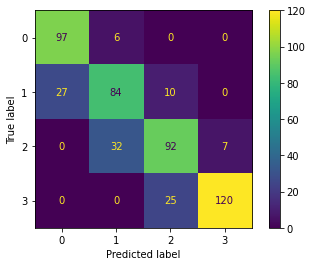

In [64]:
from sklearn.metrics import recall_score, accuracy_score, f1_score, plot_confusion_matrix
import matplotlib.pyplot as plt

y_predicted = clf.predict(X_test_prepared)

print("Recall:", recall_score(y_test, y_predicted, average='macro'))
print("Accuracy:", accuracy_score(y_test, y_predicted))
print("F1 Score:", f1_score(y_test, y_predicted, average='macro'))

plot_confusion_matrix(clf, X_test_prepared, y_test)  
plt.show() 